# Métricas de Agrupamiento (K-means y DBSCAN) (Core)

## Descripción:

En esta actividad, se utilizarán los algoritmos K-means y DBSCAN para agrupar datos del dataset «Credit Card Data» disponible en Kaggle. El objetivo es aplicar ambas técnicas de clustering y compararlas utilizando métricas como el «silhouette score» y el «calinski-harabasz index» para evaluar la calidad de los clusters obtenidos.

Enlace al dataset: https://www.kaggle.com/arjunbhasin2013/ccdata

## Objetivo:

El objetivo es comparar la efectividad de K-means y DBSCAN en el dataset seleccionado, evaluando la cohesión e intersección de los clusters obtenidos mediante métricas de evaluación. Se espera que los estudiantes comprendan las diferencias entre ambos algoritmos y cómo usar las métricas adecuadas para elegir el mejor modelo de clustering.

## Instrucciones:

### 1. Carga de datos:

* Descarga y carga el dataset «Credit Card Data» de Kaggle. Realiza una exploración inicial de las variables y observa cómo se distribuyen.
* Este dataset incluye información sobre los comportamientos de clientes de tarjetas de crédito. Variables como el monto total de gastos, el número de compras y el saldo de la cuenta son de interés para el agrupamiento.

### 2. Exploración y preprocesamiento de datos:

* Realiza una limpieza inicial de los datos, eliminando valores atípicos y manejando cualquier valor nulo presente en el dataset.
* Estandariza las variables para asegurar que el rango de las características no afecte el rendimiento de los algoritmos de clustering.
* Selecciona las características más relevantes para el análisis, como los montos de compras y la frecuencia de uso de la tarjeta.

### 3. Aplicación de K-means y DBSCAN:

* Implementa primero el algoritmo K-means para agrupar los clientes. Determina el número óptimo de clusters utilizando el método del codo y calcula el «silhouette score» para evaluar la cohesión de los clusters formados.
* Luego, aplica DBSCAN al mismo conjunto de datos. Experimenta con diferentes valores de epsilon y min_samples para obtener un clustering que capture tanto los clusters densos como los outliers.

### 4. Comparación mediante métricas:

* Calcula y compara las siguientes métricas de evaluación para ambos algoritmos:
    * Silhouette Score: Esta métrica mide cuán similares son los puntos dentro del mismo cluster en comparación con los puntos de otros clusters.
    * Calinski-Harabasz Index: Esta métrica evalúa la dispersión entre los clusters y dentro de ellos, con mayores valores indicando una mejor definición de clusters.
* Visualiza ambos agrupamientos utilizando gráficos de dispersión para comparar visualmente cómo K-means y DBSCAN dividen los datos.

### 5. Interpretación de resultados:

* Discute cuál de los dos algoritmos ofrece un mejor rendimiento en este dataset basado en las métricas calculadas. ¿Los clusters formados por K-means son más cohesivos que los obtenidos con DBSCAN?
* Analiza también los outliers detectados por DBSCAN. ¿Estos puntos tienen comportamientos inusuales en comparación con los clientes agrupados por K-means?

# Resolución

## 1. Carga de datos:

In [238]:
from utils.git_utils import get_repo_file_path
from utils.kaggle_utils import descargar_dataset_kaggle


# Asegúrarse de que el archivo kaggle.json con las credenciales de kaggle
# estén en el directorio base del repositorio.
kaggle_credentials_path = get_repo_file_path("kaggle.json")

descargar_dataset_kaggle(
    "https://www.kaggle.com/arjunbhasin2013/ccdata",
    kaggle_credentials_path,
    "../data/",
)

Skipping, found downloaded files in "../data/ccdata" (use force=True to force download)


In [239]:
import pandas as pd


camino_ds = "../data/ccdata/CC GENERAL.csv"
df = pd.read_csv(camino_ds)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

## 2. Exploración y preprocesamiento de datos.

### Realiza una limpieza inicial de los datos, eliminando valores atípicos y manejando cualquier valor nulo presente en el dataset.

In [240]:
columnas = df.columns.tolist()

columnas_convertidas_booleanas = []

valores_columnas_booleanas_potenciales = [
    [0, 1],
    [0.0, 1.0],
    ["false", "true"],
    ["no", "yes"],
    ["no", "si"],
    ["N", "Y"],
]


def _convertir_valor_a_booleano(x):
    if x in [0, 0.0, "false", "no", "no", "N"]:
        return False

    if x in [1, 1.0, "true", "yes", "si", "Y"]:
        return True

    return x


for columna in columnas:
    valores_unicos = df[columna].dropna().unique()

    columna_booleana_encontrada = False

    if len(valores_unicos) == 2:
        print(f"Valores de columna '{columna}': {str(valores_unicos)}")

        for posibilidad_valores_booleanos in valores_columnas_booleanas_potenciales:
            if set(valores_unicos) == set(posibilidad_valores_booleanos):
                print(f"La columna '{columna}' es booleana. Será convertida.")
                df[columna] = df[columna].apply(_convertir_valor_a_booleano)
                df[columna] = df[columna].astype("bool")

                columna_booleana_encontrada = True
                break

    if columna_booleana_encontrada:
        columnas_convertidas_booleanas.append(columna)


print(f"Columnas convertidas a booleanas: {str(columnas_convertidas_booleanas)}")

Columnas convertidas a booleanas: []


In [241]:
columnas_objeto_cadena = df.select_dtypes(include=["object", "string"]).columns.tolist()

In [242]:
# Se elige el 5% como valor para empezar a considerar una columna como categórica.
# Si se supera esta cantidad la columna se dejará como cadena.
porcentaje_max_columnas_categoricas = 0.05
cant_filas_df = df.shape[0]

columnas_a_excluir = []
columnas_convertidas_a_categoricas = []
columnas_convertidas_a_string = []

for columna in columnas_objeto_cadena:
    valores_unicos = df[columna].dropna().unique().tolist()
    print(f"Cant. únicos para columna '{columna}': {len(valores_unicos)}")
    if len(valores_unicos) <= (porcentaje_max_columnas_categoricas * cant_filas_df):
        
        print(f"Valores únicos columna '{columna}': {str(valores_unicos)}")
        print(f"Se procede a convertir la columna '{columna}' a categórica")
        df[columna] = df[columna].astype("category")
        columnas_convertidas_a_categoricas.append(columna)
    else:
        print(f"No se convierte la columna '{columna}' a categórica, se opta por dejarla como string")
        df[columna] = df[columna].astype("string")
        columnas_convertidas_a_string.append(columna)

    del valores_unicos

print("\n")
print(f"Cant. de columnas analizadas: {len(columnas_objeto_cadena)}")
print(f"Cant. de columnas convertidas a category: {len(columnas_convertidas_a_categoricas)}")
print(f"Cant. de columnas convertidas a string: {len(columnas_convertidas_a_string)}")
print(f"Columnas convertidas a categóricas: {str(columnas_convertidas_a_categoricas)}")
print(f"Columnas convertidas a string: {str(columnas_convertidas_a_string)}")

Cant. únicos para columna 'CUST_ID': 8950
No se convierte la columna 'CUST_ID' a categórica, se opta por dejarla como string


Cant. de columnas analizadas: 1
Cant. de columnas convertidas a category: 0
Cant. de columnas convertidas a string: 1
Columnas convertidas a categóricas: []
Columnas convertidas a string: ['CUST_ID']


In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   string 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [244]:
from utils.eda_utils import obtener_estadisticas_datos_nulos


obtener_estadisticas_datos_nulos(df)

,datos sin NAs en q,Na en q,Na en %
MINIMUM_PAYMENTS,8637,313,3.50
CREDIT_LIMIT,8949,1,0.01
CUST_ID,8950,0,0.00
BALANCE,8950,0,0.00
PRC_FULL_PAYMENT,8950,0,0.00
PAYMENTS,8950,0,0.00
PURCHASES_TRX,8950,0,0.00
CASH_ADVANCE_TRX,8950,0,0.00
CASH_ADVANCE_FREQUENCY,8950,0,0.00
PURCHASES_INSTALLMENTS_FREQUENCY,8950,0,0.00


Como hay pocos nulos en el dataset, se procede a eliminar estos datos.

In [245]:
df.dropna(inplace=True)


obtener_estadisticas_datos_nulos(df)

,datos sin NAs en q,Na en q,Na en %
CUST_ID,8636,0,0.0
BALANCE,8636,0,0.0
PRC_FULL_PAYMENT,8636,0,0.0
MINIMUM_PAYMENTS,8636,0,0.0
PAYMENTS,8636,0,0.0
CREDIT_LIMIT,8636,0,0.0
PURCHASES_TRX,8636,0,0.0
CASH_ADVANCE_TRX,8636,0,0.0
CASH_ADVANCE_FREQUENCY,8636,0,0.0
PURCHASES_INSTALLMENTS_FREQUENCY,8636,0,0.0


In [246]:
duplicados = df.duplicated()

cant_registros_duplicados = duplicados.sum()

print(f"Cant. de Registros Duplicados general: {cant_registros_duplicados}")

Cant. de Registros Duplicados general: 0


In [247]:
duplicados_customer_id = df.duplicated(["CUST_ID"])

cant_registros_duplicados_customer_id = duplicados_customer_id.sum()

print(f"Cant. de Registros Duplicados Customer ID: {cant_registros_duplicados_customer_id}")

Cant. de Registros Duplicados Customer ID: 0


No se encuentran duplicados.

In [248]:
from utils. eda_utils import obtener_columnas_numericas_df


columnas_numericas = obtener_columnas_numericas_df(df)

columnas_numericas

['BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [249]:
from utils.eda_utils import graficar_histogramas, graficar_boxplots

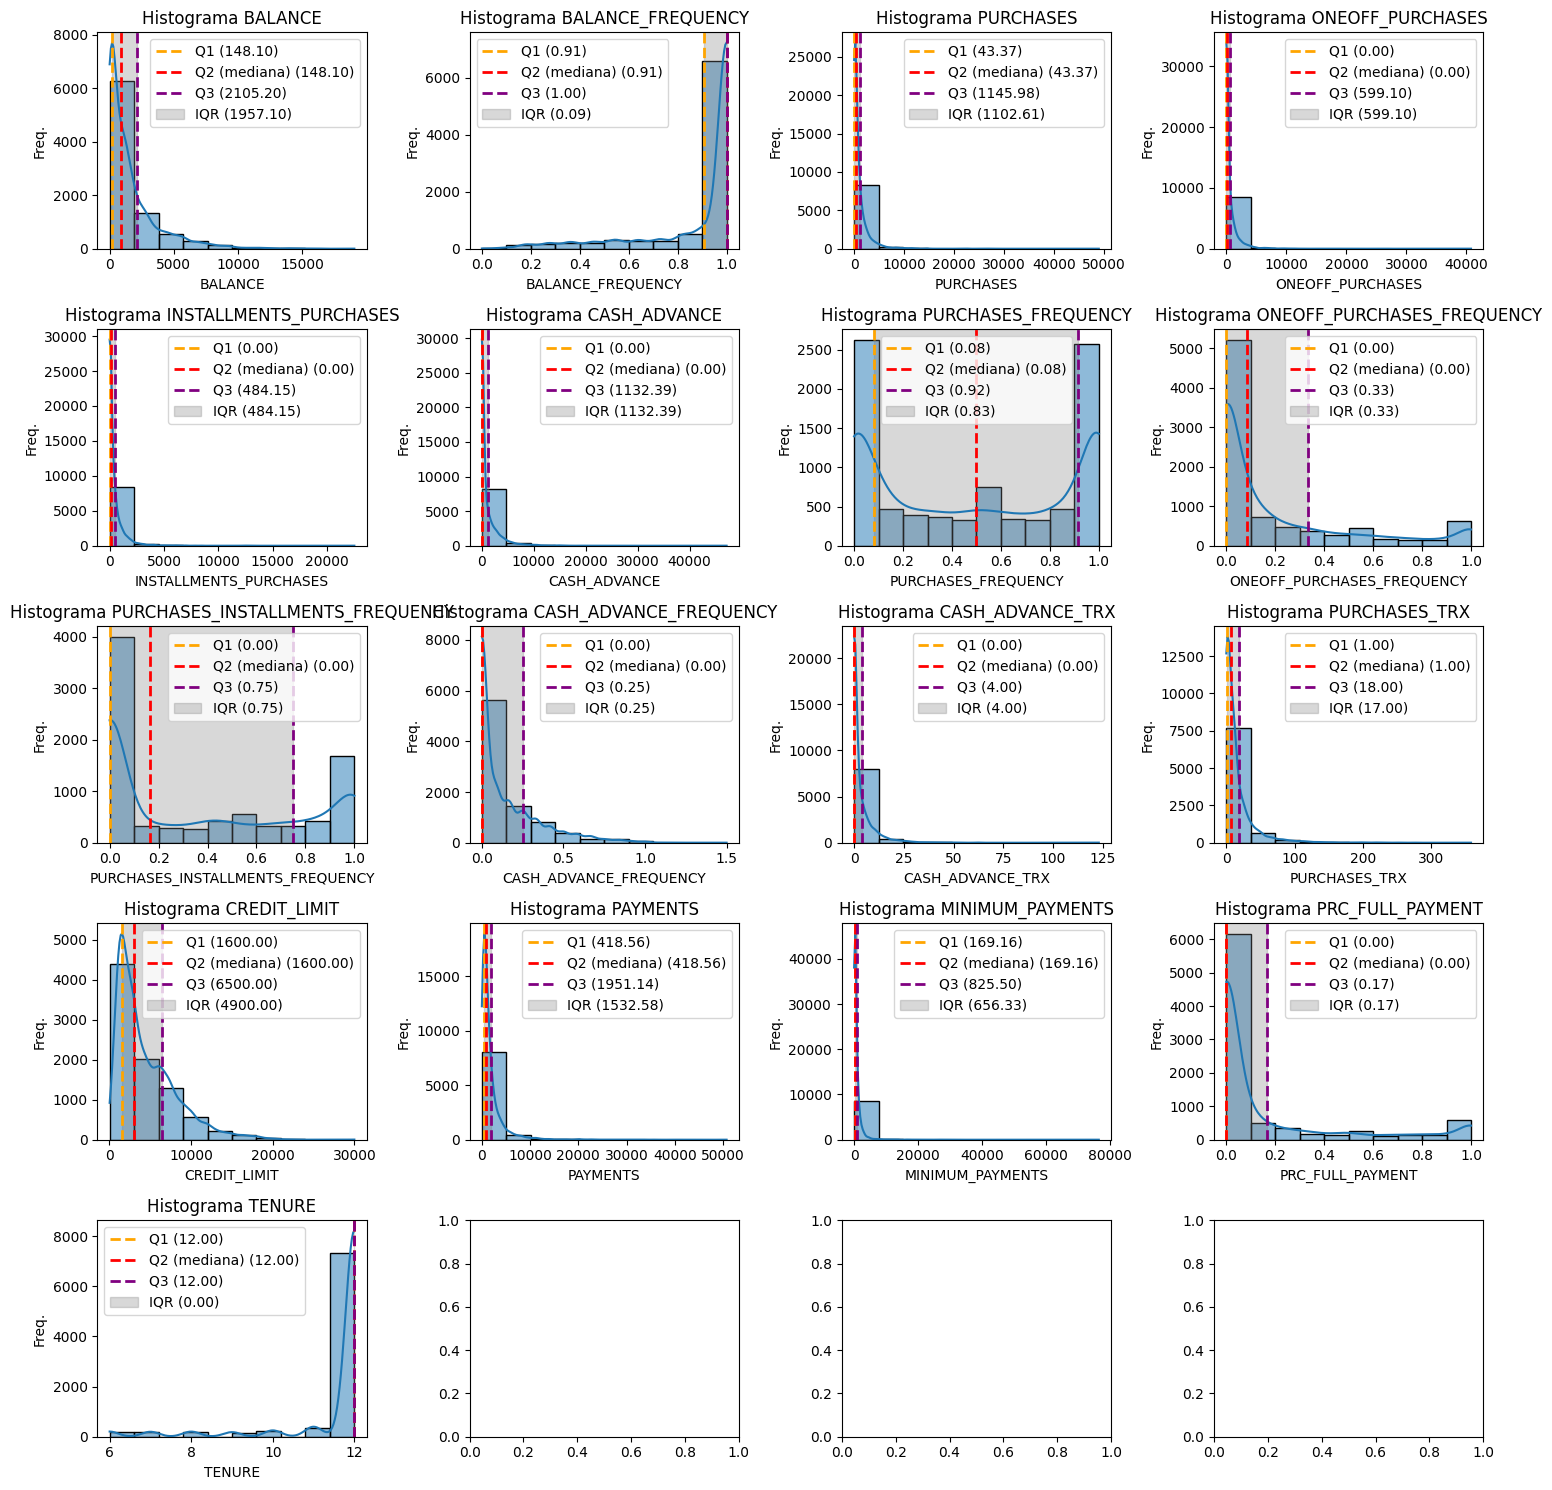

In [250]:
graficar_histogramas(df, columnas_numericas, nro_columnas=4, bins=10, kde=True, figsize=(15, 15))

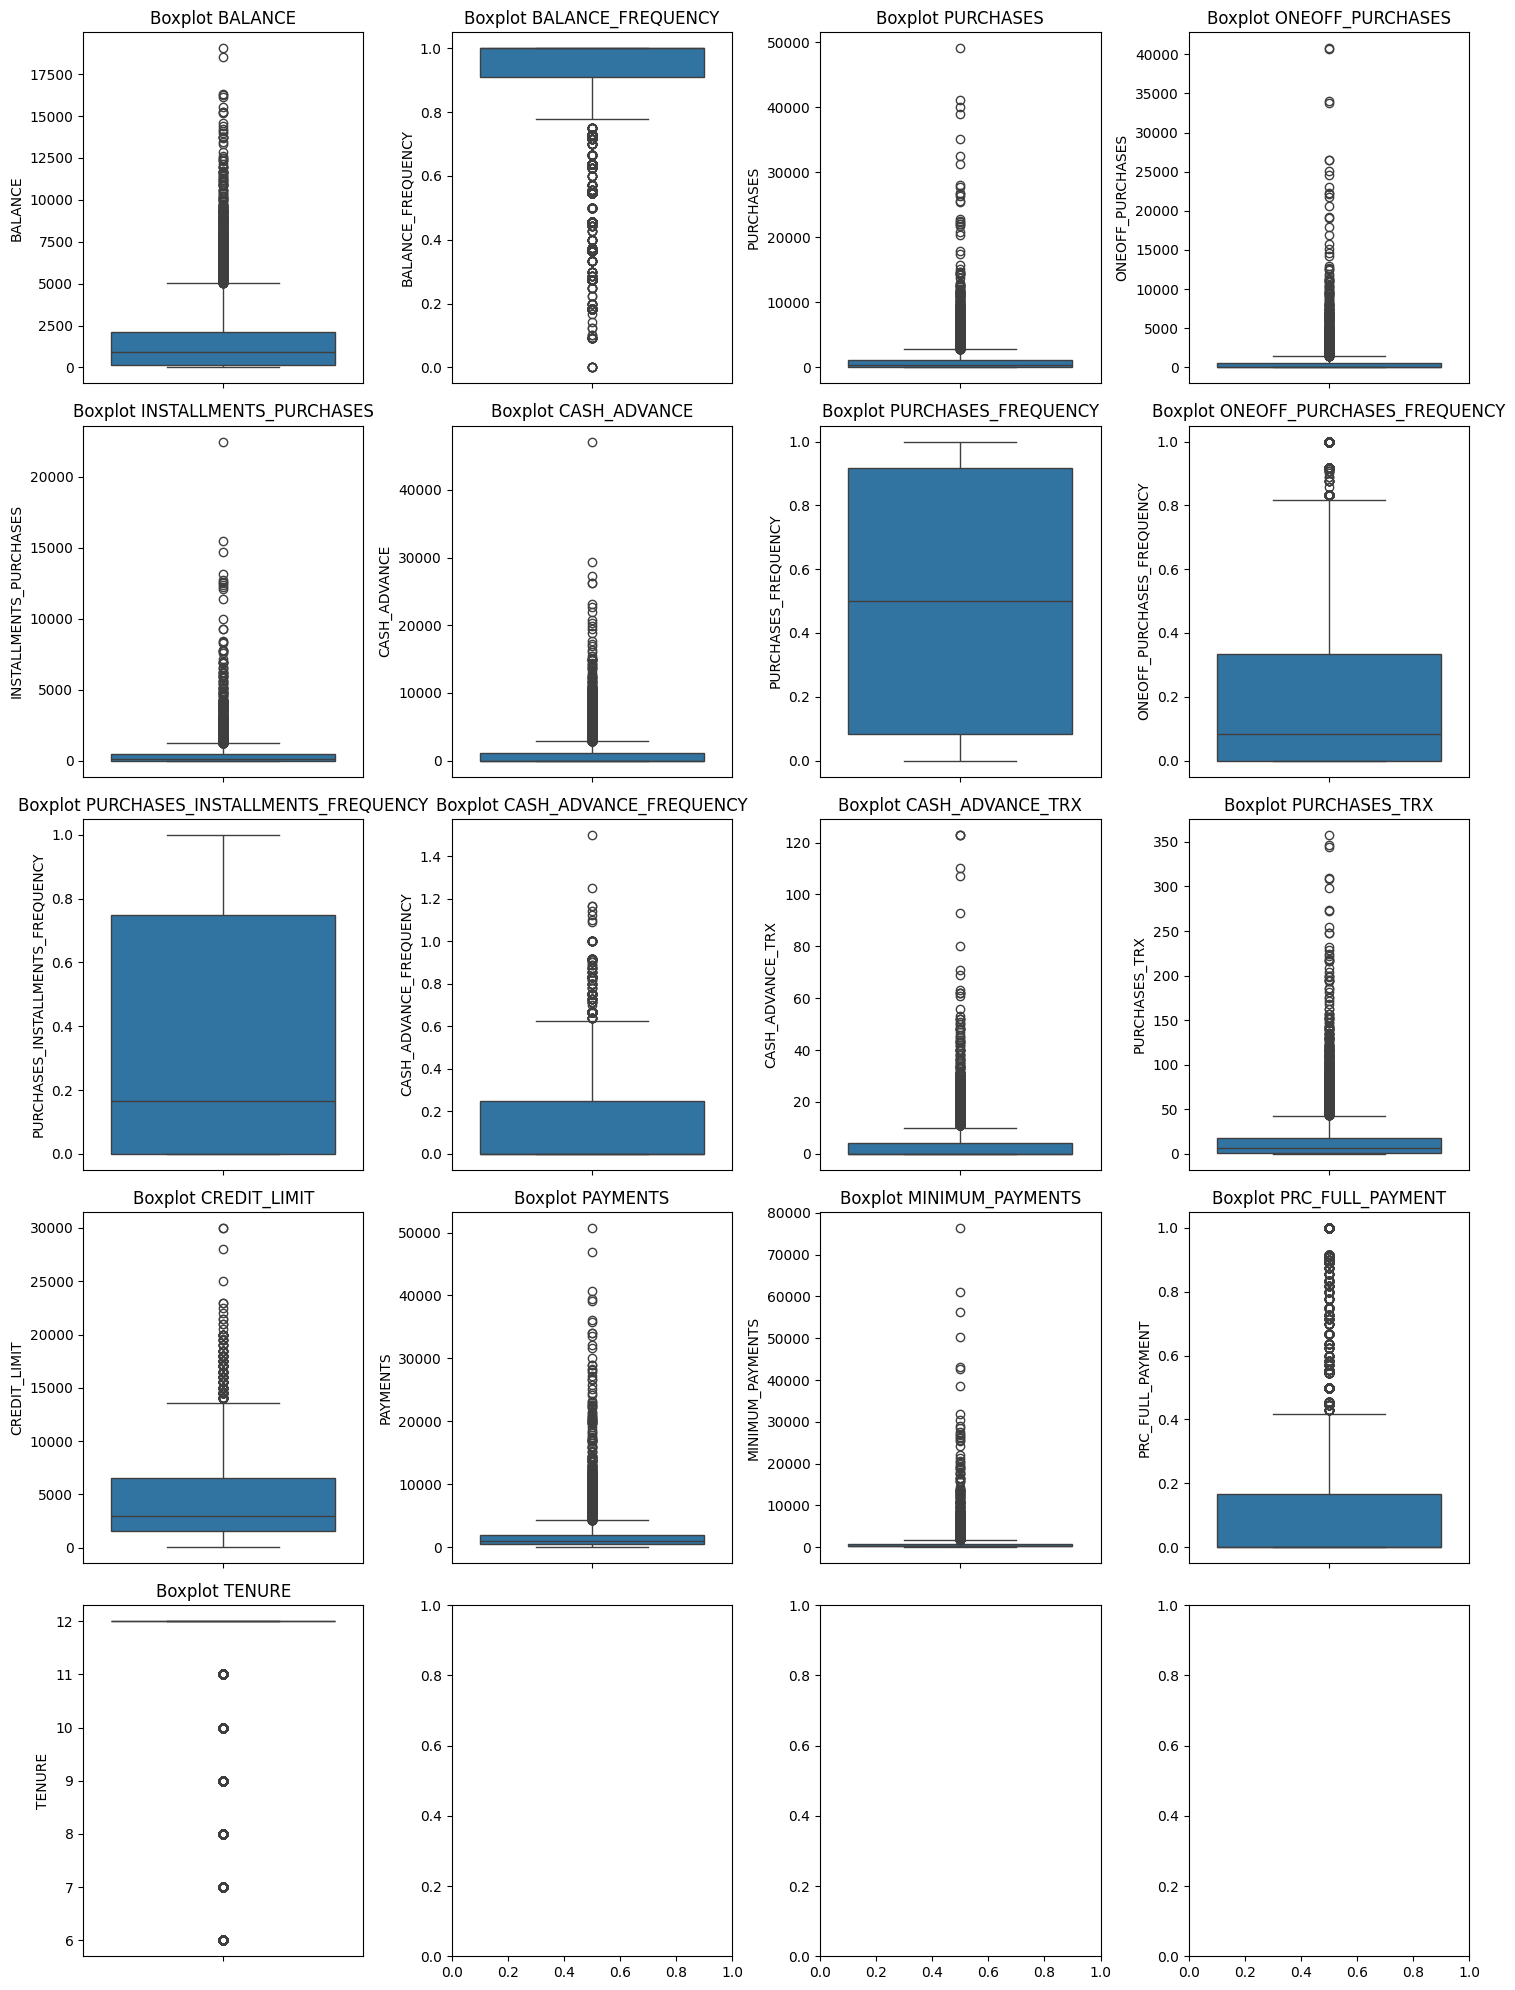

In [251]:
graficar_boxplots(df, columnas_numericas, nro_columnas=4, figsize=(15, 20))

Podemos notar que los datasets efectivamente poseen una gran cantidad de outliers.

### Estandariza las variables para asegurar que el rango de las características no afecte el rendimiento de los algoritmos de clustering.

In [252]:
columnas_numericas = obtener_columnas_numericas_df(df)

X = df[columnas_numericas]

In [253]:
df_scaled = df.copy()

for columna in columnas_numericas:
    mean = df_scaled[columna].mean()
    std_dev = df_scaled[columna].std()

    z_scores = (df_scaled[columna] - mean) / std_dev
    df_scaled[columna] = z_scores

In [254]:
df_scaled.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03,8.636000e+03
mean,-6.582147e-18,-4.015109e-16,8.227683e-18,-5.430271e-17,-3.373350e-17,-3.291073e-17,4.031565e-17,-9.873220e-18,-3.620181e-17,3.373350e-17,9.873220e-18,-8.227683e-18,7.898576e-17,-1.645537e-17,-3.620181e-17,-3.291073e-18,1.053143e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.640995e-01,-4.309334e+00,-4.731808e-01,-3.591395e-01,-4.588125e-01,-4.686284e-01,-1.236067e+00,-6.862398e-01,-9.264679e-01,-6.819130e-01,-4.794091e-01,-5.970196e-01,-1.222136e+00,-6.132457e-01,-3.642831e-01,-5.376958e-01,-4.221556e+00
25%,-6.934289e-01,6.767501e-02,-4.531691e-01,-3.591395e-01,-4.588125e-01,-4.686284e-01,-1.028396e+00,-6.862398e-01,-9.264679e-01,-6.819130e-01,-4.794091e-01,-5.573063e-01,-7.985513e-01,-4.694186e-01,-2.929913e-01,-5.376958e-01,3.551601e-01
50%,-3.265789e-01,5.053754e-01,-2.999522e-01,-3.324252e-01,-3.554759e-01,-4.686284e-01,9.968284e-03,-4.085128e-01,-5.078044e-01,-6.819130e-01,-4.794091e-01,-3.190264e-01,-4.159582e-01,-3.051066e-01,-2.325974e-01,-5.376958e-01,3.551601e-01
75%,2.404933e-01,5.053754e-01,5.562534e-02,-3.444405e-03,6.901532e-02,6.514857e-02,1.048332e+00,4.246716e-01,9.575142e-01,5.569899e-01,9.925221e-02,1.178202e-01,5.405245e-01,5.727659e-02,-1.635717e-02,2.485352e-02,3.551601e-01
max,8.323226e+00,5.053754e-01,2.215586e+01,2.384145e+01,2.407116e+01,2.175062e+01,1.256004e+00,2.646498e+00,1.585508e+00,6.751505e+00,1.731443e+01,1.362035e+01,6.962622e+00,1.681794e+01,3.183974e+01,2.837593e+00,3.551601e-01


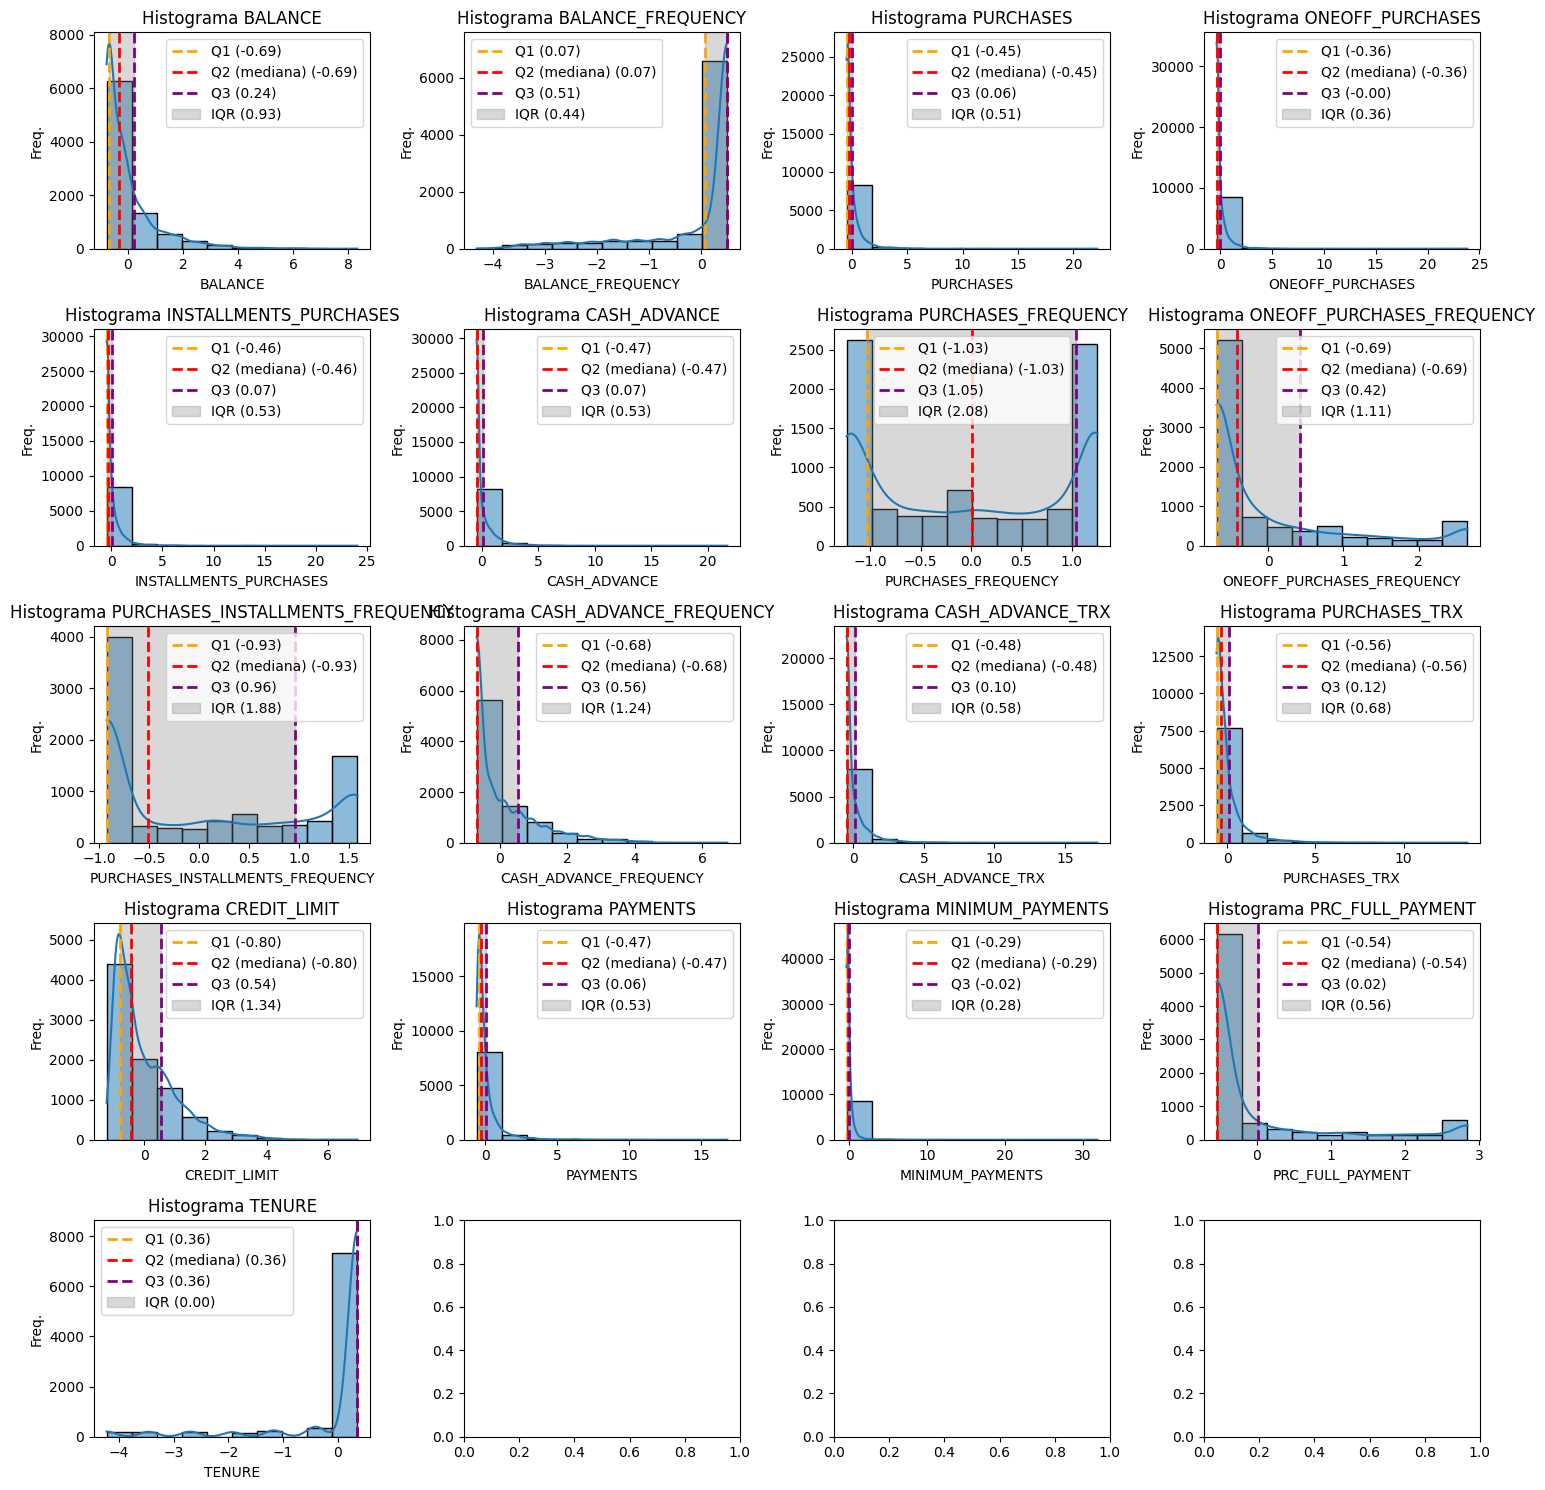

In [255]:
graficar_histogramas(df_scaled, columnas_numericas, nro_columnas=4, bins=10, kde=True, figsize=(15, 15))

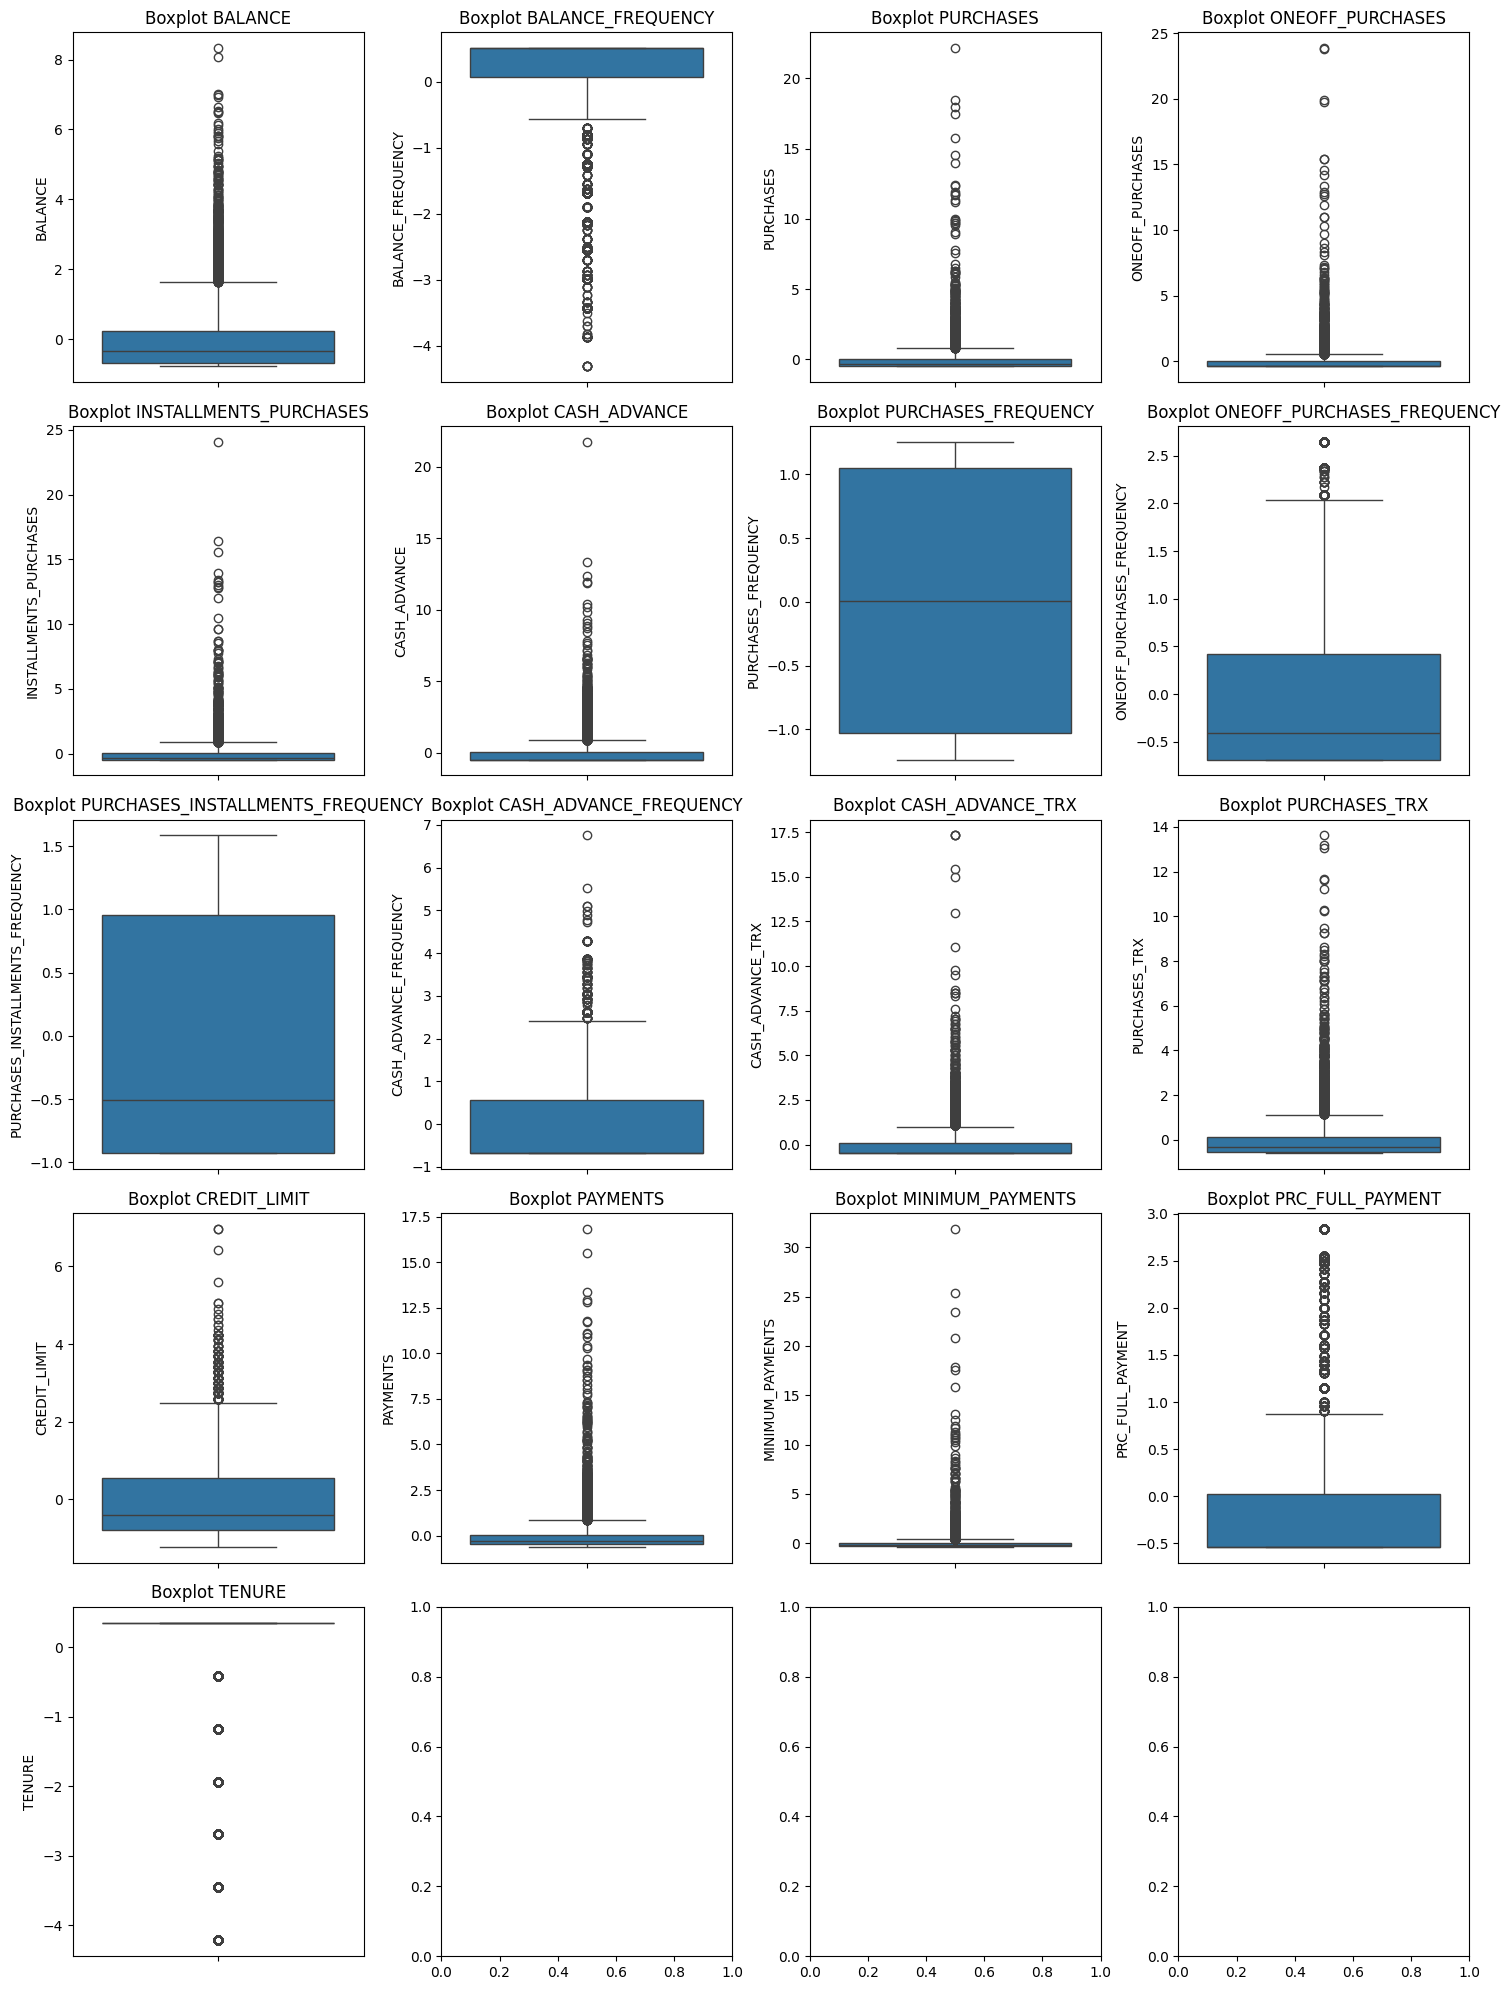

In [256]:
graficar_boxplots(df_scaled, columnas_numericas, nro_columnas=4, figsize=(15, 20))

Como se puede visualizar en las gráficas, ya todos los datos fueron estandarizados usando la técnica de escalamiento RobustScaler.

### Selecciona las características más relevantes para el análisis, como los montos de compras y la frecuencia de uso de la tarjeta.

In [257]:
X_selected = df_scaled[["PURCHASES", "PURCHASES_FREQUENCY"]]

## 3. Aplicación de K-means y DBSCAN:

In [275]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

### Implementa primero el algoritmo K-means para agrupar los clientes. Determina el número óptimo de clusters utilizando el método del codo y calcula el «silhouette score» para evaluar la cohesión de los clusters formados.

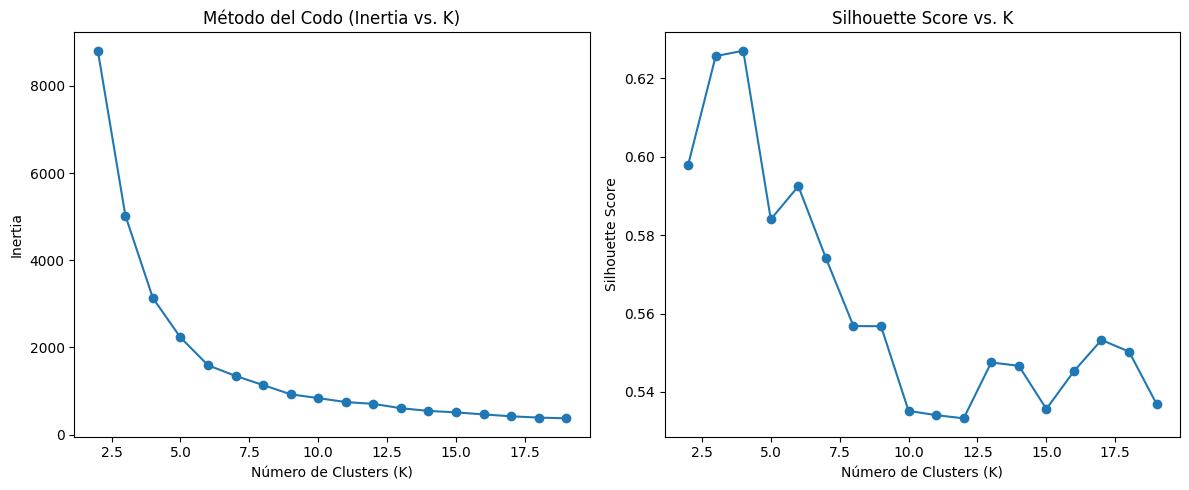

In [259]:
# Calcular Inertia y Silhouette Score para diferentes valores de K
inertia = []
silhouette_scores = []
k_values = range(2, 20)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_selected)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_selected, kmeans.labels_))

# Crear gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Inertia
ax[0].plot(k_values, inertia, marker='o')
ax[0].set_title('Método del Codo (Inertia vs. K)')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inertia')

# Gráfico de Silhouette Score
ax[1].plot(k_values, silhouette_scores, marker='o')
ax[1].set_title('Silhouette Score vs. K')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

Del gráfico de codo, podemos notar que el número de clusters K mas apropiado es K=5

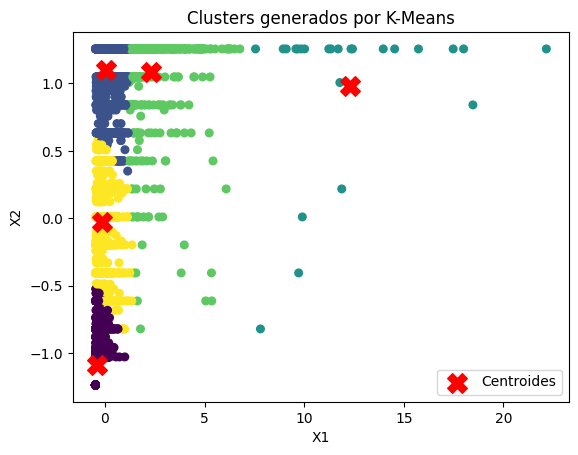

Silhouette Score: 0.58


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_selected)

y_kmeans = kmeans.predict(X_selected)

# Visualizar los clusters generados por K-Means
plt.scatter(X_selected["PURCHASES"], X_selected["PURCHASES_FREQUENCY"], c=y_kmeans, s=30, cmap='viridis')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title("Clusters generados por K-Means")
plt.xlabel("PURCHASES")
plt.ylabel("PURCHASES_FREQUENCY")
plt.legend()
plt.show()

# Calcular métrica de Silhouette
silhouette_avg = silhouette_score(X_selected, y_kmeans)
print(f"Silhouette Score: {silhouette_avg:.2f}")

### Luego, aplica DBSCAN al mismo conjunto de datos. Experimenta con diferentes valores de epsilon y min_samples para obtener un clustering que capture tanto los clusters densos como los outliers.

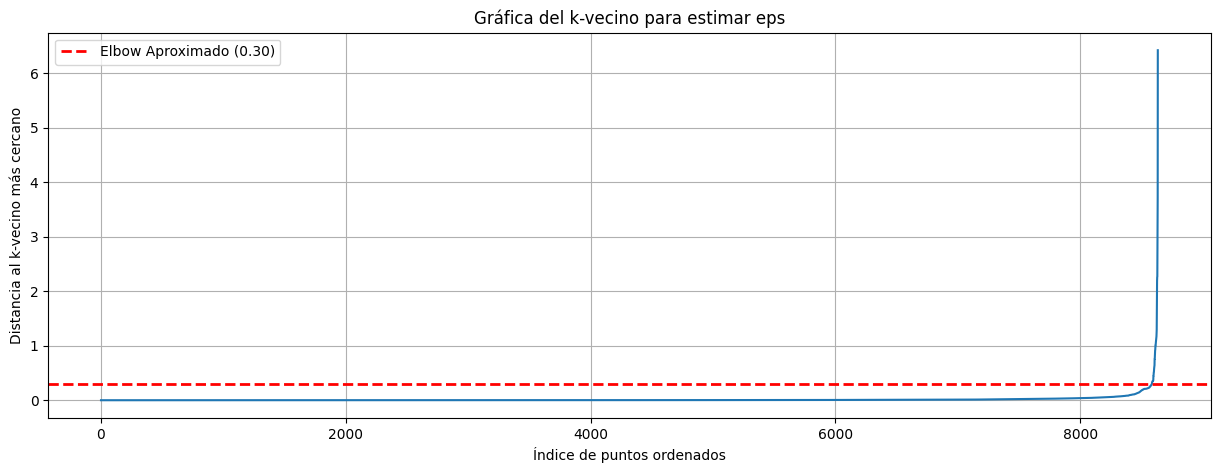

In [282]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Configurar min_samples
min_samples = 5

# Ajustar el modelo de k-vecino más cercano
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_selected)
distances, indices = nbrs.kneighbors(X_selected)

# Ordenar las distancias
distances = np.sort(distances[:, -1])

# Graficar las distancias para estimar eps
plt.figure(figsize=(15, 5))
plt.plot(distances)
plt.title('Gráfica del k-vecino para estimar eps')
plt.xlabel('Índice de puntos ordenados')
plt.ylabel('Distancia al k-vecino más cercano')
elbow = 0.3
plt.axhline(
    elbow,
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Elbow Aproximado ({elbow:.2f})"
)
plt.legend()
plt.grid()
plt.show()

In [262]:
from sklearn.cluster import DBSCAN

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(X_selected)

# Calculamos el Siboulette Score
score = silhouette_score(X, clusters)
print(score)

0.7222620314648439


In [263]:
eps = 0.3  # Usar el eps óptimo previamente estimado
min_samples_range = range(3, 15)
scores = []

for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_selected)
    if len(set(clusters)) > 1:  # Evaluar solo si hay más de un cluster
        score = silhouette_score(X_selected, clusters)
        scores.append((min_samples, score))

# Identificar el mejor min_samples
best_min_samples = max(scores, key=lambda x: x[1])
print(f"Mejor min_samples: {best_min_samples[0]} con Silhouette Score: {best_min_samples[1]:.4f}")

Mejor min_samples: 7 con Silhouette Score: 0.8249


In [264]:
from sklearn.model_selection import ParameterGrid

# Definir un rango de valores para eps y min_samples
param_grid = {
    'eps': np.arange(0.05, 0.5, 0.01),
    'min_samples': range(1, 15, 1)
}

# Crear combinaciones de parámetros
grid = ParameterGrid(param_grid)

# Variable para almacenar los mejores parámetros y resultados
best_params = None
best_score = -1
results = []

# Iterar sobre todas las combinaciones de parámetros
for params in grid:
    print(f"Ejecutando iteración con parámetros: {str(params)}")
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    clusters = dbscan.fit_predict(X_selected)
    # Calcular el Silhouette Score solo si hay más de un cluster
    if len(set(clusters)) > 1 and -1 in clusters:
        score = silhouette_score(X_selected, clusters)
        results.append((params['eps'], params['min_samples'], score))
        if score > best_score:
            best_score = score
            best_params = params

# Convertir resultados en un array para facilitar gráficos
results = np.array(results)

# Resultados óptimos
print(f"Mejores parámetros: {best_params}")
print(f"Mejor Silhouette Score: {best_score:.4f}")

# Si quieres graficar, aquí tienes las variables:
# - results[:, 0]: eps
# - results[:, 1]: min_samples
# - results[:, 2]: silhouette scores

Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 1}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 2}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 3}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 4}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 5}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 6}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 7}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 8}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 9}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 10}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 11}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 12}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 13}
Ejecutando iteración con parámetros: {'eps': 0.05, 'min_samples': 14}
Ejecutando iteración con pará

In [294]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.42, min_samples=5)
y_dbscan = dbscan.fit_predict(X_selected)

## 4. Comparación mediante métricas

In [295]:
# Calcular la Inercia
inertia_kmeans = kmeans.inertia_
print(f"Inercia KMeans: {inertia_kmeans}")

# Calcular el Silhouette Score
sil_score_kmeans = silhouette_score(X_selected, y_kmeans)
print(f"Silhouette Score KMeans: {sil_score_kmeans}")

# Calcular el Davies-Bouldin Index
db_index_kmeans = davies_bouldin_score(X_selected, y_kmeans)
print(f"Davies-Bouldin Index KMeans: {db_index_kmeans}")

# Calcular el Calinski Harabasz score
ch_score_kmeans = calinski_harabasz_score(X_selected, y_kmeans)
print(f"Calinski Harabasz score KMeans: {ch_score_kmeans}")


print("\n")

# Calcular el Silhouette Score
sil_score_db = silhouette_score(X_selected, y_dbscan)
print(f"Silhouette Score DBSCAN: {sil_score_db}")

# Calcular el Davies-Bouldin Index
db_index_db = davies_bouldin_score(X_selected, y_dbscan)
print(f"Davies-Bouldin Index DBSCAN: {db_index_db}")

# Calcular el Calinski Harabasz score
ch_score_db = calinski_harabasz_score(X_selected, y_dbscan)
print(f"Calinski Harabasz score DBSCAN: {ch_score_db}")

Inercia KMeans: 2227.4593362659566
Silhouette Score KMeans: 0.5840099319585412
Davies-Bouldin Index KMeans: 0.5872119346488308
Calinski Harabasz score KMeans: 14571.901790582273


Silhouette Score DBSCAN: 0.8632341052487255
Davies-Bouldin Index DBSCAN: 0.43681225340341334
Calinski Harabasz score DBSCAN: 2233.9080243158846


De los resultados, podemos notar: 

* La técnica dbscan brinda un mejor silhouete score (más cercano a 1 mejor)
* La técnica dbscan brinda un menor davies bouldin index (más bajo mejor)
* La técnica dbscan brinda un menor Calinski Harabasz score (mas alto mejor)

### Visualiza ambos agrupamientos utilizando gráficos de dispersión para comparar visualmente cómo K-means y DBSCAN dividen los datos.

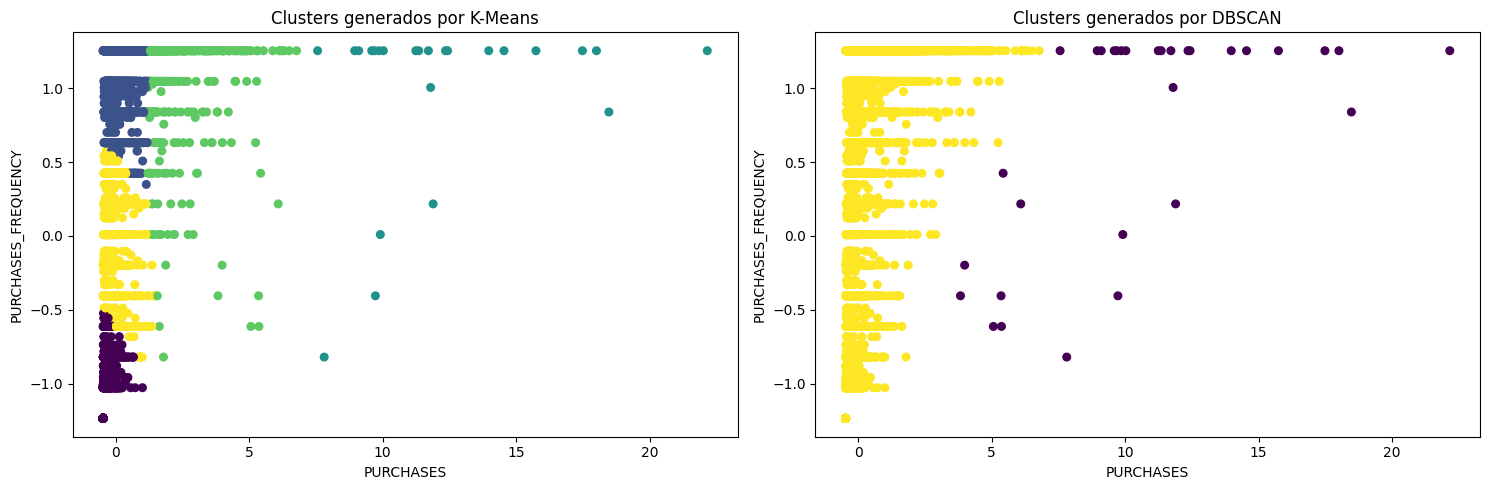

In [296]:
# Crear gráficos
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(X_selected["PURCHASES"], X_selected["PURCHASES_FREQUENCY"], c=y_kmeans, s=30, cmap='viridis')
ax[0].set_title('Clusters generados por K-Means')
ax[0].set_xlabel('PURCHASES')
ax[0].set_ylabel('PURCHASES_FREQUENCY')

ax[1].scatter(X_selected["PURCHASES"], X_selected["PURCHASES_FREQUENCY"], c=y_dbscan, s=30, cmap='viridis')
ax[1].set_title('Clusters generados por DBSCAN')
ax[1].set_xlabel('PURCHASES')
ax[1].set_ylabel('PURCHASES_FREQUENCY')

plt.tight_layout()
plt.show()

## 5. Interpretación de resultados:

### Discute cuál de los dos algoritmos ofrece un mejor rendimiento en este dataset basado en las métricas calculadas. ¿Los clusters formados por K-means son más cohesivos que los obtenidos con DBSCAN?

Considerando las métricas y las visualizaciones, DBSCAN parece ser la mejor opción para el clustering de PURCHASES y PURCHASES_FREQUENCY. Si bien, KMeans produce más agrupaciones, el método DBSCAN parece estar detectando más fácilmente datos de tipo outliers, lo que podría ser de gran utilidad para el proveedor de la tarjeta de crédito. Otra conclusión importante que se puede sacar con respecto a KMeans, es que los datos no necesariamente parecen estar tener forma circular, por lo que el KMeans no sería un método apropiado de clustering para estas columnas.